**Analyses of TDR Soil Moisture Sensor Waveform** <br />
A validation patented intellectual property <br />


In [13]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math, Latex


## Prepared by B. Keith Bellingham, <br />
Soil Scientist, <br />
October 7, 2022<br/>
https://www.linkedin.com/in/bkbellingham/


**Introduction**

Time domain reflectometry (TDR) is commonly used for the determination of the volumetric soil water content. 

Monitoring soil moisture is increasingly becoming more important for irrigation, flood and drought risk, water resources, and climate change assessments.
TDR is based on the principle that the velocity of an electrical pulse will slow down in the soil as the soil gets wetter. The travel time of the electrical pulse, T, is directly corelated to the parameter called the apparent dielectric permittivity, $K_a$ (sometimes called the relative dielectric permittivity). Knowing the time of travel of the pulse, the $K_a$ of the soil can be determined by: <br />!

$$K_a = (cT/L)^2$$

Where c is the speed of light, and L is the path length of the waveguide. The waveguide is metal part of the sensor that is in the soil through which the electrical pulse travels before reflecting back to the sensor head. 

The Topp Equation, is commonly used as the soil moisture calibration for TDRs by using the $K_a$ value to estimate soil water content; 

$$\theta = a + bK_a + cK_a^2 + dK_a^3$$

Where a, b, c, and d, are empirical coefficients. 

The measurement the travel time of the electrical pulse is the raw measurement used to determine the dielectric permittivity and thus the soil moisture.  The raw signal produced by a TDR instrument is a plot of the voltage of the pulse as a function of time called a waveform. The time the signal enters the soil (start time) and the time the signal reflects and returns to the detector (finish time) is characterized by valleys and inflections in the waveform. Mathematical and algorithmic treatment of the waveform to determine the start time and the finish time will automate the soil moisture determination and can be utilized in the TDR’s commercial software. 



**About the Dataset**

The impute file is a csv that contains the waveforms of distilled water and saturated sand. The waveguide length is 0.08 meters. The are 1200 times where the voltage signal is recorded representing a range of 12,000 picoseconds. Water is used as a reference fluid because the dielectric constant of water is 78.5 at room temperature. 


In [15]:
#Bring in and clean raw waveform data. 

wf_raw = pd.read_csv('https://raw.githubusercontent.com/KeithBellingham/Analyses-of-TDR-Soil-Moisture-Sensor-Waveform/main/Buriable%20data.csv', skiprows=2, header=None).T
wfs_df = wf_raw.drop(labels=range(0 , 23), axis=0) 

wfs_df.set_axis([ 'Time', 'Air', 'wet_sand', 'water', 'zero_test'], axis=1,inplace=True)

wfs_df.reset_index(drop=True, inplace=True)
wfs_df.head()

,Time,Air,wet_sand,water,zero_test
0,1,1695,2037,1721,1701
1,2,1726,2063,1736,1718
2,3,1721,2059,1743,1718
3,4,1726,2066,1746,1731
4,5,1725,2062,1748,1719


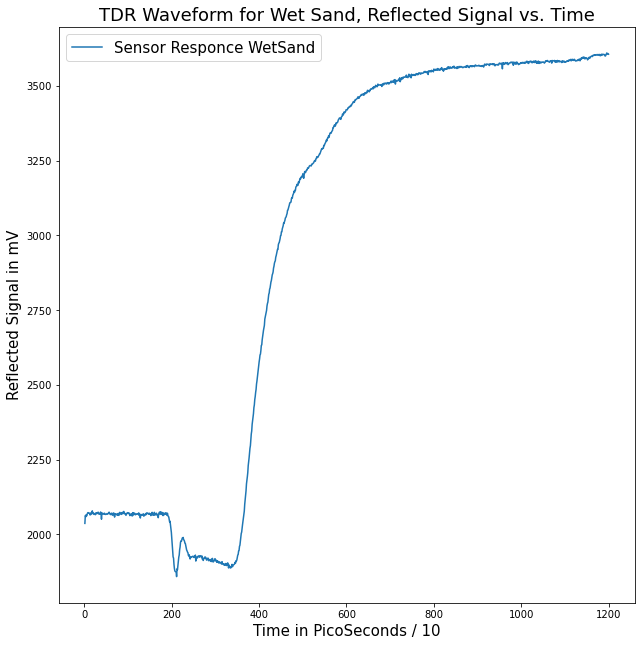

In [16]:
x = wfs_df['Time']
y = wfs_df['wet_sand']

fig_w = plt.figure(figsize=(8,8))
axes_4 = fig_w.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time in PicoSeconds / 10' ,fontsize=15)
axes_4.set_ylabel('Reflected Signal in mV',fontsize=15)
axes_4.set_title('TDR Waveform for Wet Sand, Reflected Signal vs. Time',fontsize=18)
axes_4.plot(x, y, label='Sensor Responce WetSand')
axes_4.legend(loc='best',fontsize=15)


**About the Dataset**

The impute file is a csv that contains the waveforms of distilled water and saturated sand. The waveguide length is 0.08 meters. The are 1200 times where the voltage signal is recorded representing a range of 12,00 picoseconds. Water is used as a reference fluid because the dielectric constant of water is 78.5 at room temperature. 
		

**Methods and Discussion** 
The data was smoothed using a rolling mean. The valleys in the waveform were isolated using a rolling slope that changes from negative to positive and a rolling min/max function with set windows.  The valley isolation parameters were different for the start time and the finish time. There is a maximum that occurs after the electrical pulse enters the soil caused be a change in electrical impedance on the transmission line. This “impedance bump” is not used in the calculation and should excluded.  A rolling  r, and r squared were also determined in the dataframes but were not used as a parameter for the determination of the inflections in the wave form. 


# Water

In [4]:
#Determine the dielectric permittivity for water. 
#Determine start and finish time in TDR waveform data. 

wf_water = wfs_df[['Time','water']]

# Set rolling window sizes for smoothing (rolling mean), slope, and the differnce of rolling min and max. 
smooth = 11
time_s = 13
time_f = 31
minmax_frame = 13

#Smooth waveform data. 

wf_water['water_smth'] = wf_water['water'].rolling(window=smooth, center=True).mean()

#Get rolling slope, r and r squared. 
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

def get_r_value(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return r_value


wf_water['r_value'] = wf_water['water_smth'].rolling(window=time_s, center=True,
                                min_periods=time_s).apply(get_r_value)

wf_water['r^2'] = wf_water['r_value']**2

#Find Start Time--------
wf_water['rolling_slope_s'] = wf_water['water_smth'].rolling(window=time_s, center=True,
                               min_periods=time_s).apply(get_slope)

#Find the differnce of the rolling min and rolling max. 
wf_water['minmaxdif_s'] = (wf_water['rolling_slope_s'].rolling(
    window=minmax_frame,center=True).max())-(wf_water['rolling_slope_s'].rolling(
    window=minmax_frame,center=True).min())

#Determine where the slope changes from negative to positive. 
wf_water['sign_s'] = (wf_water['rolling_slope_s'].abs())/wf_water['rolling_slope_s']
wf_water['signa_s'] = wf_water['sign_s'].rolling(window=2).sum()
sign_change_s = wf_water.loc[(wf_water['signa_s']==0)]

#Finding the start and finish time in the waveform. 
#time_df = sign_change.loc[(sign_change['minmaxdif_s']>1) & (sign_change['rolling_slope_s']>0)] 
#time_df.reset_index(drop=True, inplace=True)


#Find Finish Time---------
wf_water['rolling_slope_f'] = wf_water['water_smth'].rolling(window=time_f, center=False,
                               min_periods=time_f).apply(get_slope)

#Find the differnce of the rolling min and rolling max. 
wf_water['minmaxdif_f'] = (wf_water['rolling_slope_f'].rolling(
    window=minmax_frame,center=True).max())-(wf_water['rolling_slope_f'].rolling(
    window=minmax_frame,center=True).min())

#Determine where the slope changes from negative to positive. 
wf_water['sign_f'] = (wf_water['rolling_slope_f'].abs())/wf_water['rolling_slope_f']
wf_water['signa_f'] = wf_water['sign_f'].rolling(window=2).sum()
sign_change_f = wf_water.loc[(wf_water['signa_f']==0)]

#Finding the start and finish time in the waveform. 

time_df_s = sign_change_s.loc[(sign_change_s['minmaxdif_s']>1) & (sign_change_s['rolling_slope_s']>0)] 
time_df_f = sign_change_f.loc[(sign_change_f['minmaxdif_f']>1) & (sign_change_f['rolling_slope_f']>0)]
time_df_s.reset_index(drop=True, inplace=True)  
time_df_f.reset_index(drop=True, inplace=True)                        
                         
time_df_f

/var/folders/6d/pyfz_bmd7kvdwy7hfwpvtnqw0000gn/T/ipykernel_66429/182330590.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_water['water_smth'] = wf_water['water'].rolling(window=smooth, center=True).mean()
/var/folders/6d/pyfz_bmd7kvdwy7hfwpvtnqw0000gn/T/ipykernel_66429/182330590.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_water['r_value'] = wf_water['water_smth'].rolling(window=time_s, center=True,


,Time,water,water_smth,r_value,r^2,rolling_slope_s,minmaxdif_s,sign_s,signa_s,rolling_slope_f,minmaxdif_f,sign_f,signa_f
0,448,1094,1093.818182,0.983905,0.968069,2.615884,3.783217,1.0,2.0,0.071371,1.058101,1.0,0.0


In [6]:
# Find Ka for Water
#Start Time in seconds
ts = (time_df_s['Time'][0])/100000000000
#Finish Time in Seconds
tf = (time_df_f['Time'][0])/100000000000
t_dif = tf - ts

#Speed of light in vacuum m/s
c = 299792458
#Length of waveguide in meters
L = 0.08

#Apparent Permetivity
Ka = ((t_dif * c)/L)**2
Ka

78.21416942957157

Text(500, 2100, 'Impedance Bump')

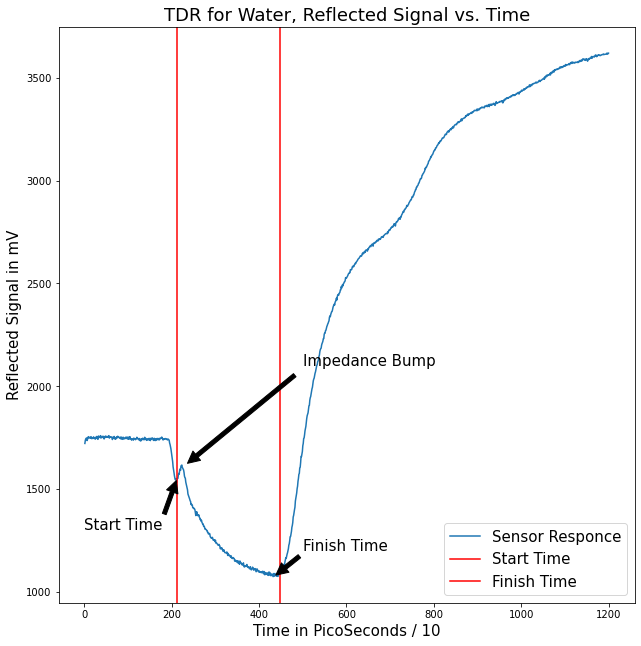

In [7]:
#Graph the waveform for water
x = wf_water['Time']
y = wf_water['water']

t_start_w = time_df_s['Time'].iloc[0]
t_finish_w = time_df_f['Time'].iloc[0]

fig_w = plt.figure(figsize=(8,8))
axes_4 = fig_w.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time in PicoSeconds / 10' ,fontsize=15)
axes_4.set_ylabel('Reflected Signal in mV',fontsize=15)
axes_4.set_title('TDR for Water, Reflected Signal vs. Time',fontsize=18)
axes_4.plot(x, y, label='Sensor Responce')


plt.axvline(x = t_start_w, color = 'r', label = 'Start Time')
plt.axvline(x = t_finish_w, color = 'r', label = 'Finish Time')

axes_4.legend(loc='best',fontsize=15)

axes_4.annotate('Start Time', xy=(212, 1550),fontsize=15, xytext=(0, 1300),
                arrowprops=dict(facecolor='black', shrink=0.05))

axes_4.annotate('Finish Time', xy=(435, 1075),fontsize=15, xytext=(500, 1200),
                arrowprops=dict(facecolor='black', shrink=0.05))

axes_4.annotate('Impedance Bump', xy=(222, 1600),fontsize=15, xytext=(500, 2100),
                arrowprops=dict(facecolor='black', shrink=0.05))

# Sand

In [11]:
wf_sand = wfs_df[['Time','wet_sand']]

# Set rolling window sizes for smoothing (rolling mean), slope, and the differnce of rolling min and max. 
smooth = 11
time_s = 13
time_f = 31
minmax_frame = 13

#Smooth waveform data. 

wf_sand['sand_smth'] = wf_sand['wet_sand'].rolling(window=smooth, center=True).mean()

#Get rolling slope, r and r squared. 
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

def get_r_value(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return r_value


wf_sand['r_value'] = wf_sand['sand_smth'].rolling(window=time_s, center=True,
                                min_periods=time_s).apply(get_r_value)

wf_sand['r^2'] = wf_sand['r_value']**2

#Find Start Time--------
wf_sand['rolling_slope_s'] = wf_sand['sand_smth'].rolling(window=time_s, center=True,
                               min_periods=time_s).apply(get_slope)

#Find the differnce of the rolling min and rolling max. 
wf_sand['minmaxdif_s'] = (wf_sand['rolling_slope_s'].rolling(
    window=minmax_frame,center=True).max())-(wf_sand['rolling_slope_s'].rolling(
    window=minmax_frame,center=True).min())

#Determine where the slope changes from negative to positive. 
wf_sand['sign_s'] = (wf_sand['rolling_slope_s'].abs())/wf_sand['rolling_slope_s']
wf_sand['signa_s'] = wf_sand['sign_s'].rolling(window=2).sum()
sign_change_s = wf_sand.loc[(wf_sand['signa_s']==0)]

#Finding the start and finish time in the waveform. 
#time_df = sign_change.loc[(sign_change['minmaxdif_s']>1) & (sign_change['rolling_slope_s']>0)] 
#time_df.reset_index(drop=True, inplace=True)


#Find Finish Time---------
wf_sand['rolling_slope_f'] = wf_sand['sand_smth'].rolling(window=time_f, center=False,
                               min_periods=time_f).apply(get_slope)

#Find the differnce of the rolling min and rolling max. 
wf_sand['minmaxdif_f'] = (wf_sand['rolling_slope_f'].rolling(
    window=minmax_frame,center=True).max())-(wf_sand['rolling_slope_f'].rolling(
    window=minmax_frame,center=True).min())

#Determine where the slope changes from negative to positive. 
wf_sand['sign_f'] = (wf_sand['rolling_slope_f'].abs())/wf_sand['rolling_slope_f']
wf_sand['signa_f'] = wf_sand['sign_f'].rolling(window=2).sum()
sign_change_f = wf_sand.loc[(wf_sand['signa_f']==0)]

#Finding the start and finish time in the waveform. 

time_df_s = sign_change_s.loc[(sign_change_s['minmaxdif_s']>1) & (sign_change_s['rolling_slope_s']>0)] 
time_df_f = sign_change_f.loc[(sign_change_f['minmaxdif_f']>1) & (sign_change_f['rolling_slope_f']>0)]
time_df_s.reset_index(drop=True, inplace=True)  
time_df_f.reset_index(drop=True, inplace=True)                        
                         
time_df_f

/var/folders/6d/pyfz_bmd7kvdwy7hfwpvtnqw0000gn/T/ipykernel_66429/3751834469.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_sand['sand_smth'] = wf_sand['wet_sand'].rolling(window=smooth, center=True).mean()
/var/folders/6d/pyfz_bmd7kvdwy7hfwpvtnqw0000gn/T/ipykernel_66429/3751834469.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_sand['r_value'] = wf_sand['sand_smth'].rolling(window=time_s, center=True,


,Time,wet_sand,sand_smth,r_value,r^2,rolling_slope_s,minmaxdif_s,sign_s,signa_s,rolling_slope_f,minmaxdif_f,sign_f,signa_f
0,227,1983,1979.181818,-0.575801,0.331547,-1.159840,10.048951,-1.0,-2.0,0.248350,7.836584,1.0,0.0
1,346,1904,1909.363636,0.973690,0.948072,3.308691,5.410090,1.0,2.0,0.007845,1.368842,1.0,0.0


In [9]:
# Find Ka  and percent moisture content for wet sand
#Start Time in seconds
ts = (time_df_s['Time'][0])/100000000000
#Finish Time in Seconds
tf = (time_df_f['Time'][1])/100000000000
t_dif = tf - ts

#Speed of light in vacuum m/s
c = 299792458
#Length of waveguide in meters
L = 0.08

#Apparent Permetivity for wet sand
Ka = ((t_dif * c)/L)**2


#Topp Equation 

topp_wfv = (-530 + 292*Ka - 5.5*Ka**2 + .043*Ka**3)/100
print("The soil moisture is ", topp_wfv,"%")
print("The permittivity is ", Ka)



The soil moisture is  40.97345546224252 %
The permittivity is  25.974024665494024


Text(500, 1800, 'Finish Time')

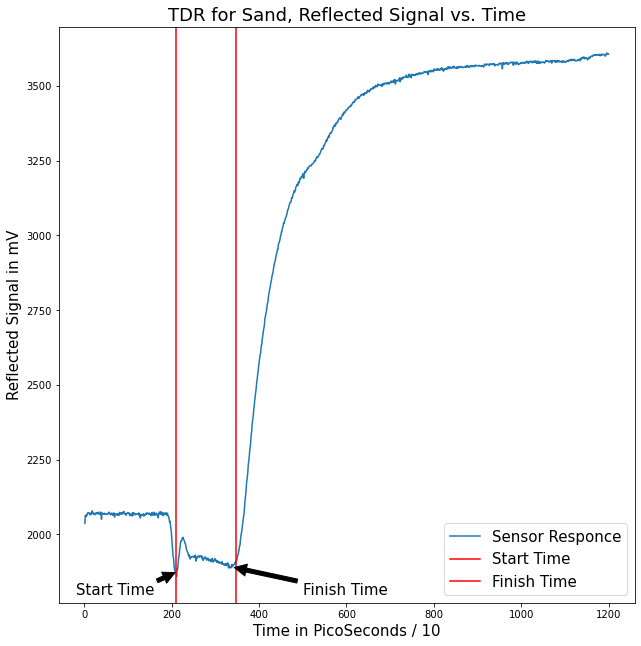

In [20]:
#Graph Wet Sand

x = wf_sand['Time']
y = wf_sand['wet_sand']

t_start_s = time_df_s['Time'].iloc[0]
t_finish_s = time_df_f['Time'].iloc[1]

fig_s = plt.figure(figsize=(8,8))
axes_4 = fig_s.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time in PicoSeconds / 10' ,fontsize=15)
axes_4.set_ylabel('Reflected Signal in mV',fontsize=15)
axes_4.set_title('TDR for Sand, Reflected Signal vs. Time',fontsize=18)
axes_4.plot(x, y, label='Sensor Responce')


plt.axvline(x = t_start_s, color = 'r', label = 'Start Time')
plt.axvline(x = t_finish_s, color = 'r', label = 'Finish Time')



#axes_4.plot(t_start, y, label = 'Start Time')
#axes_4.legend(loc="upper left")
axes_4.legend(loc='best',fontsize=15)


axes_4.annotate('Start Time', xy=(210, 1874),fontsize=15, xytext=(-20, 1800),
                arrowprops=dict(facecolor='black', shrink=0.05))

axes_4.annotate('Finish Time', xy=(335, 1892),fontsize=15, xytext=(500, 1800),
                arrowprops=dict(facecolor='black', shrink=0.05))

**Conclusion**
A rolling slope sign change and rolling difference in the min/max successfully captured the time of travel of the electric pulse for both saturated sand and water. The dielectric constant of the water was found to be 78.2 and the moisture of the wet sand was found to be 40.1%.


**References**


Dalton, F.N., Van Genuchten, M. Th. 1986. "The Time-Domain Reflectometery Method for Measuring Soil Water Content and Salinity." Geoderma 38: 237-250.
(Stevenson 2021)

Robinson, D. A., S. B. Jones, J. M. Wraith, D. Or, and S. P. Friedman. 2003. "A Review of Advances in Dielectric and Electrical Conductivity Measurement in Soils Using Time Domain Reflectometry." Vadose Zone Journal 2: 444–475.

Stevenson, M. E., M. Kumpan, F. Feichtinger, A. Scheidl, A. Eder, W. Durner, A. P. Blaschke, & P. Strauss. 2021. "Innovative method for installing soil moisture probes in a large-scale undisturbed gravel lysimeter." Vadose Zone J. 20 (https://doi.org/10.1002/vzj2.20106): e20106.



Topp, G.C., J.L. Davis, and A.P. Annan. 1980. "Electromagnetic determination of soil water content: Measurement in coaxial transmission lines." Water Resour. Res. 16: 574-582.

Whitney Scaling, Percy E. Skaling. May 30, 1995. Probe for Measuring Moisture in Soil and Other Mediums. United States of America Patent# 5420517. 


# Future EC

Text(500, 2000, 'Impedance Bump')

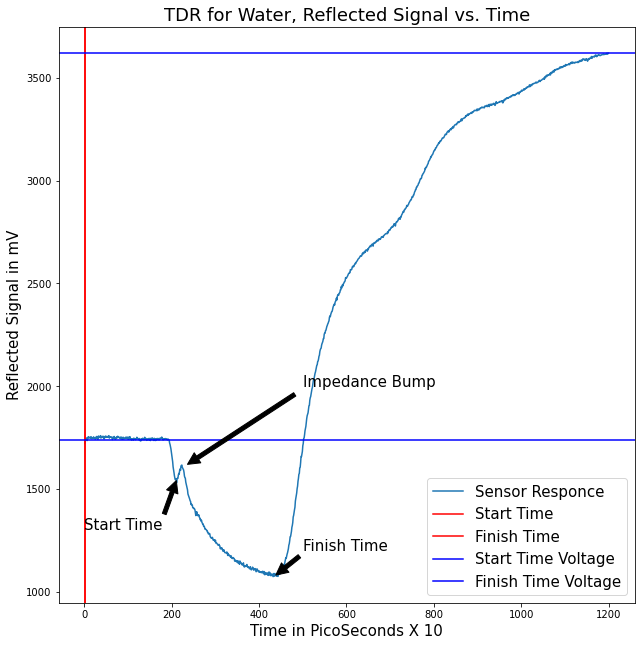

In [12]:
#Graph the min and max of waveform for future EC determination

x = wf_water['Time']
y = wf_water['water']

t_start_w = wf_water['Time'].iloc[0]
t_finish_w = wf_water['Time'].iloc[1]

top_w = wf_water['water'].iloc[1199]
bottom_w = wf_water['water'].iloc[1]

fig_w = plt.figure(figsize=(8,8))
axes_4 = fig_w.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time in PicoSeconds X 10' ,fontsize=15)
axes_4.set_ylabel('Reflected Signal in mV',fontsize=15)
axes_4.set_title('TDR for Water, Reflected Signal vs. Time',fontsize=18)
axes_4.plot(x, y, label='Sensor Responce')


plt.axvline(x = t_start_w, color = 'r', label = 'Start Time')
plt.axvline(x = t_finish_w, color = 'r', label = 'Finish Time')
plt.axhline(y = top_w, color = 'b', label = 'Start Time Voltage')
plt.axhline(y = bottom_w, color = 'b', label = 'Finish Time Voltage')

axes_4.legend(loc='best',fontsize=15)


axes_4.annotate('Start Time', xy=(212, 1550),fontsize=15, xytext=(0, 1300),
                arrowprops=dict(facecolor='black', shrink=0.05))

axes_4.annotate('Finish Time', xy=(435, 1075),fontsize=15, xytext=(500, 1200),
                arrowprops=dict(facecolor='black', shrink=0.05))

axes_4.annotate('Impedance Bump', xy=(222, 1600),fontsize=15, xytext=(500, 2000),
                arrowprops=dict(facecolor='black', shrink=0.05))